In [79]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

## Load data function

In [80]:
def read_csv_file(stock, date):
    dt = datetime.strptime(date, "%Y%m%d")
    year = dt.year
    month = dt.month

    def get_last_thursday(y, m):
        # Get last day of the month
        if m == 12:
            last_day = datetime(y + 1, 1, 1) - timedelta(days=1)
        else:
            last_day = datetime(y, m + 1, 1) - timedelta(days=1)
        offset = (last_day.weekday() - 3) % 7
        return last_day - timedelta(days=offset)

    # Determine relevant last Thursday
    last_thurs_current = get_last_thursday(year, month)

    if last_thurs_current < dt:
        # If current month's last Thursday is before the given date, go to next month
        if month == 12:
            next_month = 1
            next_year = year + 1
        else:
            next_month = month + 1
            next_year = year
        last_thurs = get_last_thursday(next_year, next_month)
    else:
        last_thurs = last_thurs_current

    last_thurs_str = last_thurs.strftime("%Y%m%d")

    # Potential file paths (no duplicates)
    file_paths = [
        f"{stock}/{year}/{year}_new/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv",  # Preferred
        f"{stock}/{year}/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv",            # Common fallback
        f"{stock}/{year}_new/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv",        # HDFC/2024_new-style
    ]

    for file_path in file_paths:
        if os.path.exists(file_path):
            return pd.read_csv(file_path)

    print("File not found in any of the expected locations:")
    for path in file_paths:
        print("  " + path)

    return None

def load_stock_data(stocks, date):
    data = []
    for stock in stocks:
        df = read_csv_file(stock, date)
        if df is None:
            raise FileNotFoundError(f"Data missing for stock: {stock}")
        data.append(df)
    return data

## Backtesting function

In [60]:
def simulate_hedged_straddle_day(
    dfs,                  # list of DataFrames for each stock
    stocks,
    weights,
    start_date,
    hedge_interval_minutes,
    lot_sizes,            # list of lot sizes per stock, e.g. [75, 125]
    strategy="H1",        # "H1" for Single Stock Approach, "H2" for Portfolio Approach
    r=0.06,
    dividend_yield=0.0,
    cash=1_000_000,
    transaction_cost_per_unit=0.0,  # cost per option contract traded
    option_transaction_cost=0.0     # cost per option contract for straddles
):
    # Prepare combined df_all_stocks with correct indexing and sorting
    processed_dfs = []
    for df in dfs:
        df = df.rename(columns={'Date Time': 'Timestamp'})
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        if 'Instrument' in df.columns:
            df['Stock'] = df['Instrument']
        else:
            raise ValueError("Each input df must have 'Instrument' column for stock name")
        processed_dfs.append(df)

    df_all_stocks = pd.concat(processed_dfs, ignore_index=True)
    index_cols = ['Timestamp', 'Stock', 'Strike', 'Type']
    df_all_stocks.set_index(index_cols, inplace=True)
    df_all_stocks.sort_index(inplace=True)

    df = df_all_stocks[df_all_stocks.index.get_level_values('Timestamp').date == pd.to_datetime(start_date).date()]

    # Hedge times
    start_time = pd.to_datetime(str(start_date) + ' 09:15:00')
    end_time = pd.to_datetime(str(start_date) + ' 15:15:00')
    hedge_times = pd.date_range(start=start_time, end=end_time, freq=f'{hedge_interval_minutes}min')

    # Helper to find closest timestamp in df for a given target_time
    def get_closest_timestamp(target_time):
        timestamps = df.index.get_level_values('Timestamp').unique()
        if len(timestamps) == 0:
            raise ValueError("No timestamps available in dataframe.")
        if target_time <= timestamps[0]:
            return timestamps[0]
        if target_time >= timestamps[-1]:
            return timestamps[-1]
        idx = timestamps.get_indexer([target_time], method='ffill')[0]
        return timestamps[idx]

    # Initialize portfolio - key addition: track straddle positions
    if strategy == "H1":
        hedge_positions = {stock: 0.0 for stock in stocks}  # Individual stock positions
    elif strategy == "H2":
        hedge_positions = {stock: 0.0 for stock in stocks}  # Portfolio hedge distributed across stocks
    else:
        raise ValueError("Strategy must be 'H1' or 'H2'")
        
    straddle_positions = {stock: {'quantity': 0, 'strike': 0, 'entry_price': 0} for stock in stocks}
    cash = float(cash)
    pnl_records = []
    initial_cash = cash

    if len(lot_sizes) != len(stocks):
        raise ValueError("lot_sizes length must match stocks length")

    # STEP 1: Initial straddle purchase at first hedge time
    first_time = hedge_times[0]
    actual_first_time = get_closest_timestamp(first_time)
    
    for i, (stock, weight) in enumerate(zip(stocks, weights)):
        lot = lot_sizes[i]
        try:
            df_stock = df.xs(stock, level='Stock')
            spot = df_stock.xs(actual_first_time, level='Timestamp')['Spot'].iloc[0]
            strikes = df_stock.index.get_level_values('Strike').unique()
            sorted_strikes = sorted(strikes, key=lambda x: abs(x - spot))  # Sort by proximity to spot

            # Find the first strike that has both CE and PE
            atm_strike = None
            for strike in sorted_strikes:
                ce_key = (actual_first_time, stock, strike, 'CE')
                pe_key = (actual_first_time, stock, strike, 'PE')
                if ce_key in df.index and pe_key in df.index:
                    atm_strike = strike
                    break

            if atm_strike is None:
                print(f"Skipping {stock}: No ATM strike with both CE and PE available at {actual_first_time}")
                continue  # Skip this stock

            # Get initial straddle prices
            ce_price = float(df.loc[(actual_first_time, stock, atm_strike, 'CE'), 'mid_price'])
            pe_price = float(df.loc[(actual_first_time, stock, atm_strike, 'PE'), 'mid_price'])

            
            # Calculate position size based on weight
            straddle_quantity = int(lot * weight)
            straddle_cost = (ce_price + pe_price) * straddle_quantity
            
            # Buy straddle
            cash -= straddle_cost
            cash -= straddle_quantity * option_transaction_cost  # Transaction cost
            
            # Record position
            straddle_positions[stock] = {
                'quantity': straddle_quantity,
                'strike': atm_strike,
                'entry_price': ce_price + pe_price
            }
            
            print(f"Initial: Bought {straddle_quantity} {stock} straddles at strike {atm_strike} for {straddle_cost:.2f}")
            
        except Exception as e:
            print(f"Error buying initial straddle for {stock}: {e}")
            continue

    # STEP 2: Regular hedging loop
    for current_time in hedge_times:
        actual_time = get_closest_timestamp(current_time)
        option_values = []
        total_deltas = []

        for i, (stock, weight) in enumerate(zip(stocks, weights)):
            lot = lot_sizes[i]
            try:
                if straddle_positions[stock]['quantity'] == 0:
                    option_values.append(0.0)
                    total_deltas.append(0.0)
                    continue
                    
                strike = straddle_positions[stock]['strike']
                quantity = straddle_positions[stock]['quantity']

                # Get current option prices and deltas for the specific strike we own
                ce_price = float(df.loc[(actual_time, stock, strike, 'CE'), 'mid_price'])
                pe_price = float(df.loc[(actual_time, stock, strike, 'PE'), 'mid_price'])
                ce_delta = float(df.loc[(actual_time, stock, strike, 'CE'), 'Delta'])
                pe_delta = float(df.loc[(actual_time, stock, strike, 'PE'), 'Delta'])

                # Current value of our straddle position
                straddle_value = (ce_price + pe_price) * quantity
                
                # Total delta for our position
                total_delta = (ce_delta + pe_delta) * quantity

                option_values.append(straddle_value)
                total_deltas.append(total_delta)
                
            except Exception as e:
                print(f"Error processing {stock} at {actual_time}: {e}")
                option_values.append(0.0)
                total_deltas.append(0.0)
                continue

        # Hedge adjustment based on strategy
        if strategy == "H1":
            # H1: Single Stock Approach - hedge each stock individually
            for i, (stock, weight) in enumerate(zip(stocks, weights)):
                if straddle_positions[stock]['quantity'] == 0:
                    continue
                    
                old_pos = hedge_positions[stock]
                required_hedge = -total_deltas[i]  # -w_j*d^t_j for stock j
                trade_qty = required_hedge - old_pos
                
                if abs(trade_qty) > 0.01:  # Only trade if meaningful change
                    trade_cost = abs(trade_qty) * transaction_cost_per_unit
                    cash -= trade_cost

                    try:
                        spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                        cash -= trade_qty * spot_price  # Buy/sell stock
                        hedge_positions[stock] = required_hedge
                    except Exception as e:
                        print(f"Error hedging {stock}: {e}")
                        
        elif strategy == "H2":
            # H2: Portfolio Approach - calculate total portfolio delta and distribute hedge
            total_portfolio_delta = sum(total_deltas)  # OD^t = sum of all deltas
            
            if abs(total_portfolio_delta) > 0.01:  # Only hedge if meaningful portfolio delta
                # Calculate total portfolio hedge needed: -OD^t * sum(w_i * F_i)
                # Since we're using spot prices, we distribute the hedge proportionally by weight
                total_portfolio_hedge = -total_portfolio_delta
                
                # Get current total hedge position
                current_total_hedge = sum(hedge_positions.values())
                total_trade_qty = total_portfolio_hedge - current_total_hedge
                
                if abs(total_trade_qty) > 0.01:
                    # Distribute the portfolio hedge proportionally across stocks by weight
                    for i, (stock, weight) in enumerate(zip(stocks, weights)):
                        if straddle_positions[stock]['quantity'] == 0:
                            continue
                            
                        # Calculate this stock's portion of the portfolio hedge
                        stock_hedge_portion = total_portfolio_hedge * weight
                        old_pos = hedge_positions[stock]
                        trade_qty = stock_hedge_portion - old_pos
                        
                        if abs(trade_qty) > 0.01:
                            trade_cost = abs(trade_qty) * transaction_cost_per_unit
                            cash -= trade_cost

                            try:
                                spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                                cash -= trade_qty * spot_price  # Buy/sell stock
                                hedge_positions[stock] = stock_hedge_portion
                            except Exception as e:
                                print(f"Error hedging {stock} in H2: {e}")

        # Calculate portfolio values
        option_value_total = sum(option_values)
        hedge_value = 0.0
        
        for stock in stocks:
            if hedge_positions[stock] != 0:
                try:
                    spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                    hedge_value += hedge_positions[stock] * spot_price
                except:
                    pass

        total_portfolio_value = option_value_total + hedge_value + cash

        pnl_records.append({
            "Timestamp": current_time,
            "OptionValue": option_value_total,
            "HedgeValue": hedge_value,
            "Cash": cash,
            "TotalValue": total_portfolio_value,
            "PnL": total_portfolio_value - initial_cash,
            "Strategy": strategy,
            "TotalPortfolioDelta": sum(total_deltas) if strategy == "H2" else None
        })

    # STEP 3: End-of-day unwind - sell all positions
    final_time = hedge_times[-1]
    actual_final_time = get_closest_timestamp(final_time)
    total_itm_loss = 0.0

    for i, stock in enumerate(stocks):
        if straddle_positions[stock]['quantity'] == 0:
            continue
            
        quantity = straddle_positions[stock]['quantity']
        strike = straddle_positions[stock]['strike']
        
        try:
            # Get final spot price
            spot = df.xs((actual_final_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
            
            # Get final option prices
            ce_price = float(df.loc[(actual_final_time, stock, strike, 'CE'), 'mid_price'])
            pe_price = float(df.loc[(actual_final_time, stock, strike, 'PE'), 'mid_price'])
            
            # Sell the straddles
            straddle_proceeds = (ce_price + pe_price) * quantity
            cash += straddle_proceeds
            cash -= quantity * option_transaction_cost  # Transaction cost for selling
            
            # Calculate ITM loss (intrinsic value lost)
            if spot > strike:
                # Call is ITM
                itm_value = max(0, spot - strike) * quantity
                total_itm_loss += itm_value
            elif spot < strike:
                # Put is ITM
                itm_value = max(0, strike - spot) * quantity
                total_itm_loss += itm_value
            
            print(f"Final: Sold {quantity} {stock} straddles for {straddle_proceeds:.2f}, ITM loss: {itm_value if spot != strike else 0:.2f}")
            
        except Exception as e:
            print(f"Error unwinding {stock}: {e}")

        # Close hedge position
        old_hedge_pos = hedge_positions[stock]
        if abs(old_hedge_pos) > 0.01:
            try:
                spot_price = df.xs((actual_final_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                cash += old_hedge_pos * spot_price  # Close hedge position
                hedge_positions[stock] = 0.0
            except Exception as e:
                print(f"Error closing hedge for {stock}: {e}")

    final_portfolio_value = cash
    total_pnl = final_portfolio_value - initial_cash

    pnl_df = pd.DataFrame(pnl_records)
    final_report = {
        "initial_cash": initial_cash,
        "final_cash": cash,
        "total_pnl": total_pnl,
        "total_itm_loss": total_itm_loss,
        "strategy_used": strategy
    }

    return pnl_df, final_portfolio_value, final_report

## Use case

In [ ]:
# S_1 = read_csv_file(stocks[0], start_date)
# S_2 = read_csv_file(stocks[1], start_date)
# S_3 = read_csv_file(stocks[2], start_date)

In [81]:
hedge_intervals = 5 # hedge interval in minutes
stocks = ["TATAMOTORS", "TCS", "TITAN"] # Available "ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"
weight = [1/len(stocks)] * len(stocks) # weights for the assets
start_date = "20240101"

# Lot_sizes
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')

lot_sizes = []

for symbol in stocks:
    symbol = symbol.strip().upper()
    lot_size_row = df[df['Symbol'] == symbol]

    if not lot_size_row.empty:
        lot_size = lot_size_row['LOT_SIZE'].values[0]
    else:
        lot_size = None

    lot_sizes.append(lot_size)

In [82]:
pnl_df, total_value, final_report = simulate_hedged_straddle_day(
    load_stock_data(stocks, start_date),  
    stocks=stocks,
    weights=weight,
    start_date=start_date,
    hedge_interval_minutes=hedge_intervals,
    lot_sizes=lot_sizes,
    strategy="H2",
    r=0.06,
    dividend_yield=0.0,
    cash=1000000,
    transaction_cost_per_unit=0.01,
    option_transaction_cost=0.01
)

Initial: Bought 183 TATAMOTORS straddles at strike 790.0 for 9767.62
Initial: Bought 58 TCS straddles at strike 3800.0 for 12588.90
Initial: Bought 58 TITAN straddles at strike 3700.0 for 10848.90
Final: Sold 183 TATAMOTORS straddles for 9392.48, ITM loss: 975.39
Final: Sold 58 TCS straddles for 12281.50, ITM loss: 1856.00
Final: Sold 58 TITAN straddles for 10487.85, ITM loss: 328.86


In [83]:
print("Final Total Portfolio Value:", total_value)
print("\nFinal Report:")
for key, value in final_report.items():
    print(f"{key}: {value}")

print("\nPnL DataFrame (first few rows):")
print(pnl_df.head())

Final Total Portfolio Value: 998731.7613776631

Final Report:
initial_cash: 1000000.0
final_cash: 998731.7613776631
total_pnl: -1268.2386223368812
total_itm_loss: 3160.250000000012
strategy_used: H2

PnL DataFrame (first few rows):
            Timestamp  OptionValue    HedgeValue          Cash    TotalValue  \
0 2024-01-01 09:15:00    33205.425 -27144.625356  9.939361e+05  9.999969e+05   
1 2024-01-01 09:20:00    33391.775 -56232.766191  1.023052e+06  1.000211e+06   
2 2024-01-01 09:25:00    33126.825 -59302.250178  1.026063e+06  9.998878e+05   
3 2024-01-01 09:30:00    33167.100 -58837.593853  1.025630e+06  9.999590e+05   
4 2024-01-01 09:35:00    33153.550 -80815.459670  1.047577e+06  9.999147e+05   

          PnL Strategy  TotalPortfolioDelta  
0   -3.088062       H2             9.806183  
1  211.496511       H2            20.335705  
2 -112.234553       H2            21.423346  
3  -40.968680       H2            21.266600  
4  -85.292758       H2            29.195176  


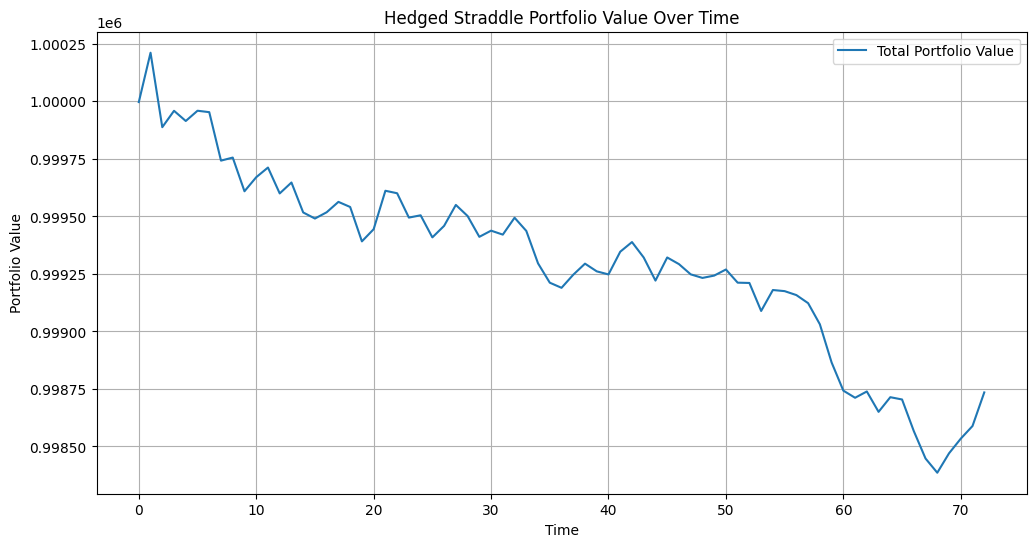

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['TotalValue'], label='Total Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Hedged Straddle Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
def run_yearly_backtest(
    year,
    stocks,
    weights,
    lot_sizes,
    strategy,  # Initially added for "H1" and "H2"
    hedge_interval_minutes=5,
    initial_cash=1000000
):
    cash = initial_cash
    full_pnl_df = pd.DataFrame()
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y%m%d')

        dfs = [read_csv_file(stock, date_str) for stock in stocks]

        if all(df is not None for df in dfs):
            print(f"Running backtest for date: {date_str}")
            try:
                pnl_df, total_val, report = simulate_hedged_straddle_day(
                    dfs=dfs,
                    stocks=stocks,
                    weights=weights,
                    start_date=current_date,
                    hedge_interval_minutes=hedge_interval_minutes,
                    lot_sizes=lot_sizes,
                    strategy=strategy,
                    cash=cash,
                    r=0.06,
                    dividend_yield=0.0,
                    transaction_cost_per_unit=0.01,
                    option_transaction_cost=0.01
                )
                cash = report['final_cash']  # carry forward cash
                pnl_df['Date'] = current_date.date()
                full_pnl_df = pd.concat([full_pnl_df, pnl_df], ignore_index=True)
            except Exception as e:
                print(f"Error on {date_str}: {e}")
        else:
            print(f"Data missing for one or more stocks on {date_str}")

        current_date += timedelta(days=1)

    return cash, full_pnl_df

In [ ]:
hedge_intervals = 5 # hedge interval in minutes
stocks = ["ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"] # Available "ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"
weight = [1/len(stocks)] * len(stocks) # weights for the assets
start_date = "20240101"

In [21]:
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')
lot_size_map = dict(zip(df['Symbol'], df['LOT_SIZE']))

lot_sizes = [lot_size_map.get(symbol.strip().upper()) for symbol in stocks]

In [22]:
final_cash, yearly_pnl = run_yearly_backtest(
    year=2024,
    stocks=stocks,
    weights=weight,
    lot_sizes=lot_sizes
)

Running backtest for date: 20240101
Initial: Bought 37 BAJAJ-AUTO straddles at strike 6800.0 for 15546.47
Initial: Bought 62 BAJFINANCE straddles at strike 7350.0 for 27345.10
Final: Sold 37 BAJAJ-AUTO straddles for 14507.70, ITM loss: 1862.21
Final: Sold 62 BAJFINANCE straddles for 25785.80, ITM loss: 599.54
Running backtest for date: 20240102
Initial: Bought 37 BAJAJ-AUTO straddles at strike 6750.0 for 14405.02
Initial: Bought 62 BAJFINANCE straddles at strike 7350.0 for 26351.55
Final: Sold 37 BAJAJ-AUTO straddles for 13549.40, ITM loss: 2466.79
Final: Sold 62 BAJFINANCE straddles for 25289.80, ITM loss: 7357.54
Running backtest for date: 20240103
Initial: Bought 37 BAJAJ-AUTO straddles at strike 6700.0 for 13381.05
Initial: Bought 62 BAJFINANCE straddles at strike 7450.0 for 24542.70
Final: Sold 37 BAJAJ-AUTO straddles for 16872.92, ITM loss: 9324.00
Final: Sold 62 BAJFINANCE straddles for 23970.75, ITM loss: 1343.54
Running backtest for date: 20240104
Initial: Bought 37 BAJAJ-AUTO

In [42]:
yearly_pnl.head()

,Timestamp,OptionValue,HedgeValue,Cash,TotalValue,PnL,Date
0,2024-01-01 09:15:00,42891.575,-27721.861575,984829.258137,999998.971562,-1.028438,2024-01-01
1,2024-01-01 09:20:00,42747.725,-17890.744621,975043.436373,999900.416751,-99.583249,2024-01-01
2,2024-01-01 09:25:00,41922.200,-16383.866792,973546.681453,999085.014661,-914.985339,2024-01-01
3,2024-01-01 09:30:00,41929.925,-22762.549308,979922.714486,999090.090178,-909.909822,2024-01-01
4,2024-01-01 09:35:00,41875.600,-25762.769603,982916.801985,999029.632381,-970.367619,2024-01-01


In [26]:
final_cash

928351.5641099804

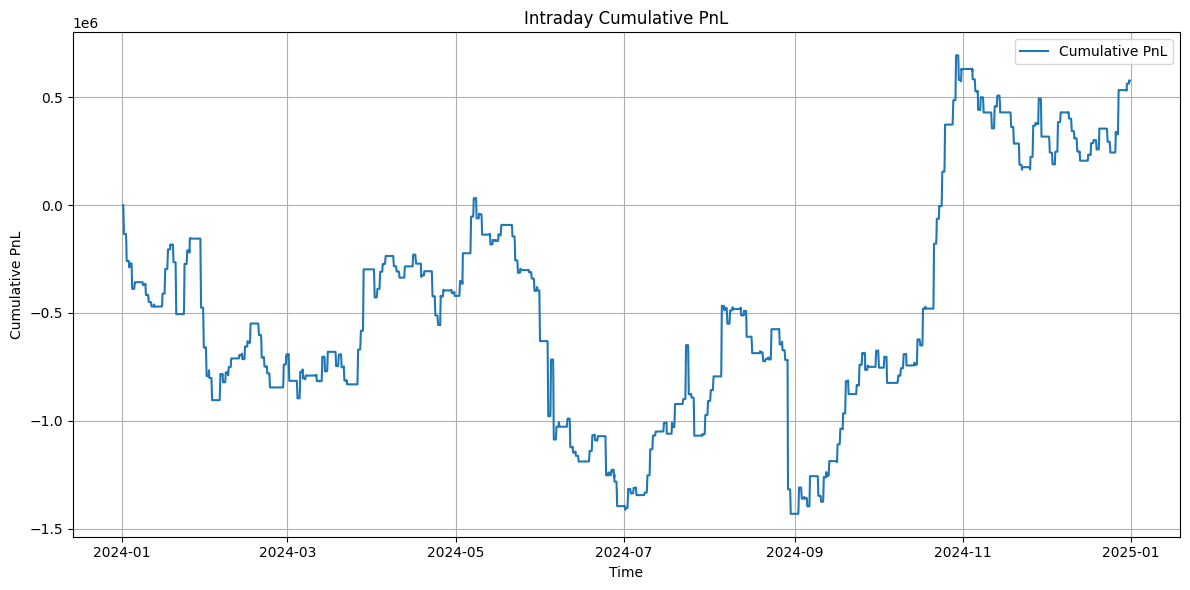

In [43]:
import matplotlib.pyplot as plt

# Ensure Timestamp is datetime
yearly_pnl['Timestamp'] = pd.to_datetime(yearly_pnl['Timestamp'])

# Cumulative PnL over time for a single day
yearly_pnl['CumulativePnL'] = yearly_pnl['PnL'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_pnl['Timestamp'], yearly_pnl['CumulativePnL'], label='Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Intraday Cumulative PnL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


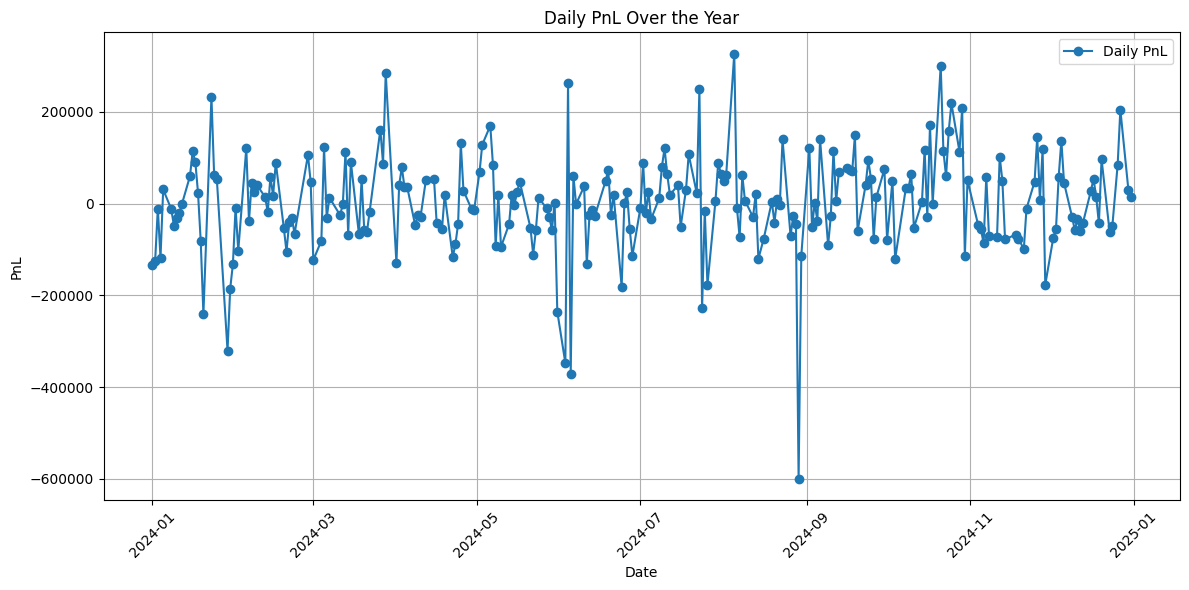

In [44]:
daily_pnl = yearly_pnl.groupby('Date')['PnL'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl['Date'], daily_pnl['PnL'], marker='o', label='Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.title('Daily PnL Over the Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


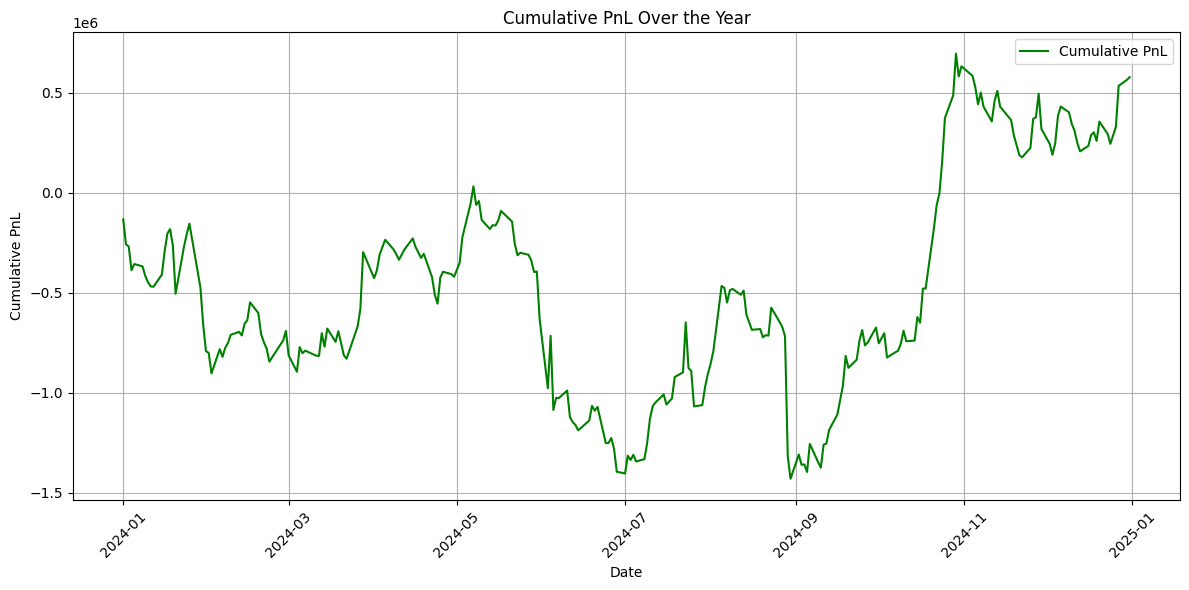

In [45]:
daily_pnl['CumulativePnL'] = daily_pnl['PnL'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl['Date'], daily_pnl['CumulativePnL'], color='green', label='Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over the Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
